# Cross correlation with WISE Catalog 

In [1]:
import sys, os
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from cmass_modules import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def reddening_cat(cat, reddening_map = None):
    
    reddening = reddening_map
    
    cathpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=4096, nest=False)
    mind = np.arange(hp.nside2npix(4096))
    reliable_hp_mask = (reddening < 0.05/0.367)
    reliable_hpind = mind[reliable_hp_mask]
    reliable_mask = np.in1d(cathpind, reliable_hpind)
    
    print cat.size,
    cat = cat[reliable_mask]
    print cat.size
    
    return cat

In [3]:
def BOSSveto(cat, option='SGC'):
    
    if option == 'SGC':
        valid_hpind = fitsio.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12SGC-COMPSAM_V6C.fits')
    elif option == 'NGC': 
        valid_hpind = fitsio.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C.fits')

    hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=4096, nest= False)
    HPmask = np.in1d(hpind, valid_hpind)
    
    return cat[HPmask]

In [4]:
def moon_cont_mask(cat):
    
    mask = np.zeros(cat.size, dtype = 'bool') #(cat['MOON_LEV']=='0000')
    #combinations = []
    for i in [0,1,2]:
        for j in [0,1,2]:
            for k in [0,1,2]:
                for l in [0,1,2]:
                    filt = '{}{}{}{}'.format(i,j,k,l)
                    mask +=(cat['MOON_LEV']==filt)
    return mask
 

In [5]:
def making_healpix_density_map(cat = None, nside = 128, nest = False):
    hpind = np.arange(hp.nside2npix(nside))
    cat_ind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside, nest= nest)
    N_gal, _ = np.histogram(cat_ind, bins = np.append(hpind, hpind.size) )
    unseen = (N_gal != 0.0)
    pixarea = hp.nside2pixarea(nside = nside)
    ra,dec = hpHEALPixelToRaDec(hpind)
    Map = np.zeros( (hpind.size, ), dtype = [('RA', 'float'),('DEC', 'float'),('PIXEL', 'float'), ('N_GAL', 'float') \
                                            , ('WEIGHT', 'float') , ('WEIGHT_RAND', 'bool') ])
    Map['RA'] = ra
    Map['DEC'] = dec
    Map['PIXEL'] = hpind
    Map['N_GAL'] = N_gal*1./pixarea    
    Map['WEIGHT'] = N_gal*1./pixarea 
    Map['WEIGHT_RAND'] = unseen
    return Map

In [6]:
#from astropy.table import Table
#t = Table.read('/n/des/lee.5922/data/wise_cat/wise_allsky.allsky_4band_p3as_psd25158.tbl', format='ipac')
#t.write('/n/des/lee.5922/data/wise_cat/wise_allsky.allsky_4band_p3as_psd25158.fits', format='fits', overwrite=True)

# Calling DES-CMASS

In [7]:
rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/'
inputdir = rootdir
figoutdir = inputdir+'/figure/'
sysoutdir = inputdir+'/sys/'
actdir = inputdir + '/act/'
wdir = sysoutdir+'/weights/'
os.system('mkdir '+inputdir)
os.system('mkdir '+figoutdir)
os.system('mkdir '+sysoutdir)
os.system('mkdir '+wdir)
#os.system('cp ../data_txt/systematics/4th/systematic*_no_weight.txt '+inputdir+'/.')

256

In [87]:
dmass_spt = io.SearchAndCallFits(path= rootdir, keyword='dmass_spt_sys_v3.fits')
dmass_random = io.SearchAndCallFits(path= rootdir, keyword='random_x50_dmass_spt_masked.fits')
#dmass_random = Cuts.keepGoodRegion(uniform_random_on_sphere(dmass_spt, size = dmass_spt.size * 30 ))

dmass_spt = appendColumn(dmass_spt, name = 'WEIGHT', value = np.ones(dmass_spt.size))
dmass_spt['WEIGHT'] = dmass_spt['CMASS_PROB'] * dmass_spt['WEIGHT_SYS']
dmass_spt = dmass_spt[dmass_spt['CMASS_PROB'] > 0.01 ]


--------------------------------
 calling catalog
--------------------------------
dmass_spt_sys_v3.fits

--------------------------------
 calling catalog
--------------------------------
random_x50_dmass_spt_masked.fits


# Calling CMASS

In [101]:
#CMASS SGC
path = '/n/des/lee.5922/data/cmass_cat/'
cmass = esutil.io.read([path+'galaxy_DR12v5_CMASS_South.fits.gz',
                        #path+'galaxy_DR12v5_CMASS_North.fits.gz'
                       ], combine=True)
random = esutil.io.read([path+'random0_DR12v5_CMASS_South.fits.gz',
                         #path+'random0_DR12v5_CMASS_North.fits.gz'
                        ], combine=True)

cmass_ngc = esutil.io.read([#path+'galaxy_DR12v5_CMASS_South.fits.gz',
                        path+'galaxy_DR12v5_CMASS_North.fits.gz'
                       ], combine=True)
random_ngc = esutil.io.read([#path+'random0_DR12v5_CMASS_South.fits.gz',
                         path+'random0_DR12v5_CMASS_North.fits.gz'
                        ], combine=True)

In [102]:
cmass = BOSSveto(cmass, option='SGC')
random = BOSSveto(random, option='SGC')

cmass_ngc = BOSSveto(cmass_ngc, option='NGC')
random_ngc = BOSSveto(random_ngc, option='NGC')

In [9]:
#randind = np.random.choice(cmass.size, size = 1000)

In [18]:
#random = construct_jk_catalog( random, njack = 10, root='./test/', 
#                           jtype = 'generate', jfile = 'jkregion_test.txt', suffix = '', retind=True )

X (13234, 2)  centers (10, 2)  tol=1e-05  maxiter=200
66 iterations  cluster sizes: [1331 1327 1112 1317 1225 1508 1340 1567 1112 1395]
X (43787993, 2)  centers (10, 2)  tol=1e-05  maxiter=200


KeyboardInterrupt: 

# Calling WISE Extended source catalog

In [152]:
wise = esutil.io.read('/n/des/lee.5922/data/wise_cat/wise_allsky.allsky_4band_p3as_psd25158.fits', upper=True)
wise_random_in_cmass = uniform_random_on_sphere(cmass, size = cmass.size * 50 )

In [13]:
wise = BOSSveto(wise, option='SGC')
#cont_mask = moon_cont_mask(wise)
#wise = wise[cont_mask]
wise_random_in_cmass = BOSSveto(wise_random_in_cmass, option='SGC')

In [153]:
wise_ngc = BOSSveto(wise, option='NGC')

In [158]:
wise_ngc.size, cmass_ngc.size

(548656, 579507)

In [ ]:
from fitsio import FITS
gama_wise = FITS('/n/des/lee.5922/data/gama_cat/GAMA-WISECat.fits')
gama_spec = FITS('/n/des/lee.5922/data/gama_cat/SpecObj.fits')

gama_id1 = gama_wise[1]['CATAID'].read()
gama_id2 = gama_spec[1]['CATAID'].read()
print gama_id1.size, gama_id2.size
#gama_obj_mask =np.in1d( gama_id2, gama_id1 )


m_gw, m_spec = esutil.numpy_util.match(gama_id1, gama_id2)

#ra = gama_spec[1]['RA'].read()[ramask]
#dec = gama_spec[1]['DEC'].read()[ramask]

ra_gw = gama_wise[1]['RA'].read()[m_gw]
dec_gw = gama_wise[1]['DEC'].read()[m_gw]
redshift = gama_spec[1]['Z'].read()[m_spec]

#desig = gama_wise[1]['DESIG_ALLWISE'].read()[m_gw]

print redshift.size

import esutil
h = esutil.htm.HTM(10)
m_gw, m_wise, _ = h.match( ra_gw, dec_gw, wise_ngc['RA'], wise_ngc['DEC'], 3./3600, maxmatch=1)
#m_gw, m_wise = esutil.numpy_util.match( desig , wise_ngc['DESIGNATION'])

redshift_common = redshift[m_gw]
wise_ngc_common = wise_ngc[m_wise]

print m_wise.size

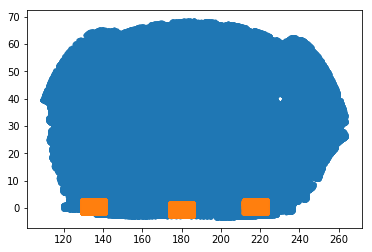

In [151]:
fig, ax = plt.subplots()

ax.plot(wise_ngc['RA'], wise_ngc['DEC'], '.')
ax.plot(ra_gw, dec_gw, '.')

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


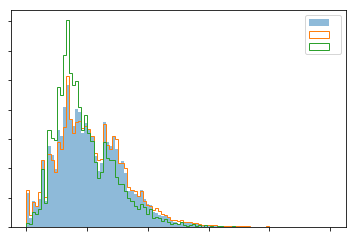

In [176]:
fig, ax = plt.subplots()
bins = np.linspace(0,1,100)
ax.hist( redshift, bins=bins, normed=True, alpha=0.5, label='wise-gamma' )
ax.hist( gama_spec[1]['Z'].read(), bins=bins, normed=True, histtype='step', label='gamma' )
ax.hist( redshift_common, bins=bins, normed=True, histtype='step' , label='common'  )

ax.legend()


In [110]:
wise['DESIGNATION']

masked_array(data=['J221252.91+243227.4', 'J221233.64+241717.7',
                   'J221200.01+250000.5', ..., 'J024635.12+020704.5',
                   'J024634.83+020705.3', 'J024640.67+020734.8'],
             mask=[False, False, False, ..., False, False, False],
       fill_value='N/A',
            dtype='|S19')

In [112]:
gama_wise_desig = gama_wise['WISECat']['DESIG_ALLWISE'].read()

In [122]:
ind1, ind2 = esutil.numpy_util.match(gama_wise_desig, wise_ngc['DESIGNATION'])
print ind1.size

1532


In [126]:
import esutil
h = esutil.htm.HTM(10)
m1, m2, _ = h.match( wise_ngc['RA'], wise_ngc['DEC'], ra2, dec2, 3./3600, maxmatch=1)
m1.size

10866

In [118]:
m1.size

0

In [111]:
help(matchCatalogs)

Help on function matchCatalogs in module utils:

matchCatalogs(cat1, cat2, tag='tagname')



0.7179895766937873
0
0.9337727353997692


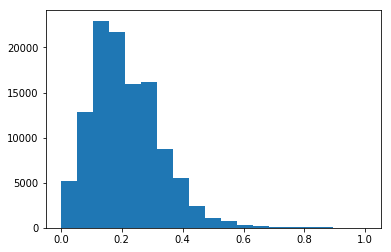

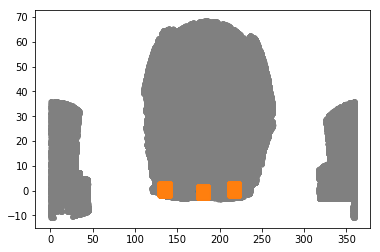

In [104]:
from fitsio import FITS
gama_wise = FITS('/n/des/lee.5922/data/gama_cat/GAMA-WISECat.fits')
gama_spec = FITS('/n/des/lee.5922/data/gama_cat/SpecObj.fits')

gama_id1 = gama_wise[1]['CATAID'].read()
gama_id2 = gama_spec[1]['CATAID'].read()
gama_id1.size, gama_id2.size
gama_obj_mask =np.in1d( gama_id2, gama_id1 )
print np.sum(gama_obj_mask) * 1./160026


ramask = gama_spec[1]['RA'].read() > 100

fig, ax = plt.subplots()
bins = np.linspace(0,1,20)
ax.hist( gama_spec[1]['Z'].read()[gama_obj_mask&ramask], bins=bins )
ax.hist( gama_spec[1]['Z'].read()[gama_obj_mask&ramask], bins=bins )
print 0



fig, ax = plt.subplots()


ramask = gama_spec[1]['RA'].read() > 100

ra = gama_spec[1]['RA'].read()[ramask]
dec = gama_spec[1]['DEC'].read()[ramask]

ra2 = gama_wise[1]['RA'].read()
dec2 = gama_wise[1]['DEC'].read()


ax.plot(cmass_ngc['RA'], cmass_ngc['DEC'], '.', color = 'grey')
ax.plot(cmass['RA'], cmass['DEC'], '.', color = 'grey')
ax.plot(ra, dec, '.')
ax.plot(ra2, dec2, '.')
ramask = gama_spec[1]['RA'].read() > 100
Nspec = np.sum(ramask)
print np.sum(gama_obj_mask)*1./Nspec

# Masking Reddening

In [39]:
mapname = '/n/des/lee.5922/data/systematic_maps/ebv_sfd98_fullres_nside_4096_nest_equatorial.fits'
#mapname = '/n/des/lee.5922/data/systematic_maps/ebv_lenz17_nside_4096_nest_equatorial.fits'
reddening = hp.read_map(mapname)
#hpIndices = np.arange(reddening_ring.size)

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [15]:
wise = reddening_cat(wise, reddening_map = reddening)
wise_random_in_cmass = reddening_cat(wise_random_in_cmass, reddening_map = reddening)
#cmass = reddening_cat(cmass, reddening_map = reddening)
#random = reddening_cat(random, reddening_map = reddening)
#dmass_spt = reddening_cat(dmass_spt, reddening_map = reddening)
#dmass_random = reddening_cat(dmass_random, reddening_map = reddening)

203465 202481
1633038 1626294


# Moon Contamination Masking

In [26]:
Healpix_config = {}
Healpix_config['out_nside'] = 128
Healpix_config['nest'] = False
wise = HealPixifyCatalogs(catalog=wise, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
wise_random_in_cmass = HealPixifyCatalogs(catalog=wise_random_in_cmass, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
#cmass = HealPixifyCatalogs(catalog=cmass, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
#random = HealPixifyCatalogs(catalog=random, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
#dmass_spt = HealPixifyCatalogs(catalog=dmass_spt, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
#dmass_random = HealPixifyCatalogs(catalog=dmass_random, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')

In [27]:
# obtain moon contamination mask from wise catalog 
wise_galmap = making_healpix_density_map(cat = wise, nest = False, nside = 128)
reliable_hpind_moonrev = wise_galmap['PIXEL'][ wise_galmap['WEIGHT_RAND'] ==1 ]

In [47]:
fitsio.write('/n/des/lee.5922/data/wise_cat/hpind_moonrev_nside256.fits', reliable_hpind_moonrev)

In [28]:
reliable_wise_mask = np.in1d(wise['HEALIndex'], reliable_hpind_moonrev)
print 'wise:', wise.size,
wise = wise[reliable_wise_mask]
print wise.size

reliable_wise_random_in_cmass_mask = np.in1d(wise_random_in_cmass['HEALIndex'], reliable_hpind_moonrev)
print 'wise random in cmass:', wise_random_in_cmass.size,
wise_random_in_cmass = wise_random_in_cmass[reliable_wise_random_in_cmass_mask]
print wise_random_in_cmass.size


"""
reliable_cmass_mask = np.in1d(cmass['HEALIndex'], reliable_hpind_moonrev)
print 'cmass:', cmass.size, 
cmass = cmass[reliable_cmass_mask]
print cmass.size

reliable_random_mask = np.in1d(random['HEALIndex'], reliable_hpind_moonrev)
print 'random:', random.size,
random = random[reliable_random_mask]
print random.size

reliable_dmass_spt_mask = np.in1d(dmass_spt['HEALIndex'], reliable_hpind_moonrev)
print 'dmass_spt:', dmass_spt.size, 
dmass_spt = dmass_spt[reliable_dmass_spt_mask]
print dmass_spt.size

reliable_dmass_random_mask = np.in1d(dmass_random['HEALIndex'], reliable_hpind_moonrev)
print 'dmass_random:', dmass_random.size, 
dmass_random = dmass_random[reliable_dmass_random_mask]
print dmass_random.size
"""

wise: 202481 202481
wise random in cmass: 1626294 1624973


"\nreliable_cmass_mask = np.in1d(cmass['HEALIndex'], reliable_hpind_moonrev)\nprint 'cmass:', cmass.size, \ncmass = cmass[reliable_cmass_mask]\nprint cmass.size\n\nreliable_random_mask = np.in1d(random['HEALIndex'], reliable_hpind_moonrev)\nprint 'random:', random.size,\nrandom = random[reliable_random_mask]\nprint random.size\n\nreliable_dmass_spt_mask = np.in1d(dmass_spt['HEALIndex'], reliable_hpind_moonrev)\nprint 'dmass_spt:', dmass_spt.size, \ndmass_spt = dmass_spt[reliable_dmass_spt_mask]\nprint dmass_spt.size\n\nreliable_dmass_random_mask = np.in1d(dmass_random['HEALIndex'], reliable_hpind_moonrev)\nprint 'dmass_random:', dmass_random.size, \ndmass_random = dmass_random[reliable_dmass_random_mask]\nprint dmass_random.size\n"

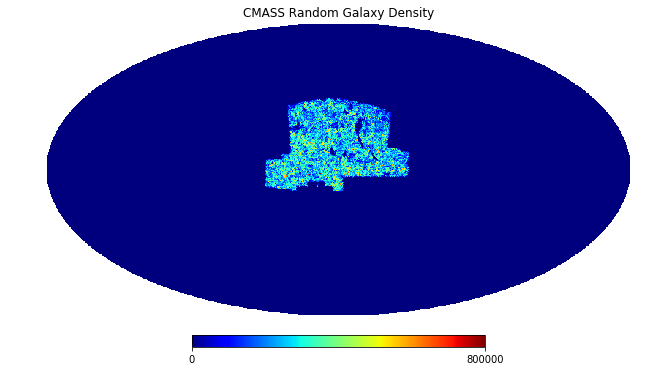

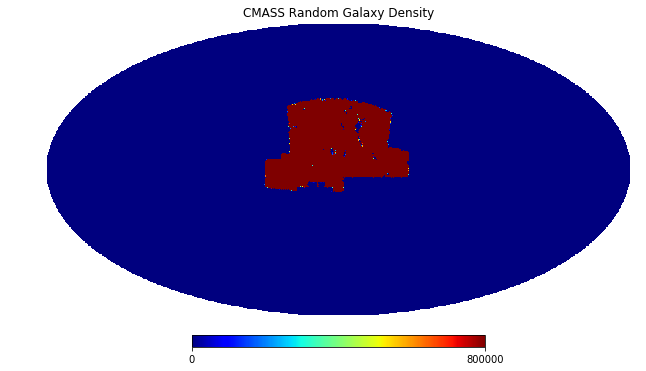

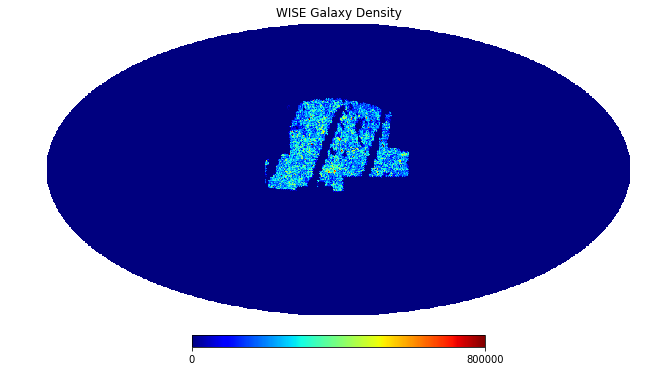

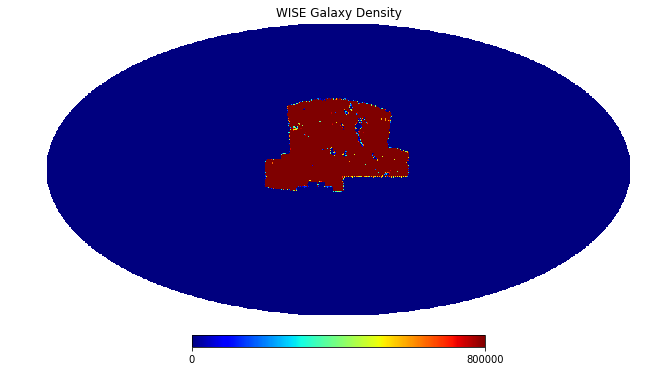

In [133]:
cmass_galmap = making_healpix_density_map(cat = cmass, nest = False, nside = 128)
hp.mollview(cmass_galmap['WEIGHT'],  nest=False, title="CMASS Random Galaxy Density", max = 8e+05)

random_galmap = making_healpix_density_map(cat = random, nest = False, nside = 128)
hp.mollview(random_galmap['WEIGHT'],  nest=False, title="CMASS Random Galaxy Density", max = 8e+05)

wise_in_cmass_galmap = making_healpix_density_map(cat = wise_in_cmass, nest = False, nside = 128)
hp.mollview(wise_in_cmass_galmap['WEIGHT'], nest=False, title="WISE Galaxy Density", max = 8e+05)

wise_random_in_cmass_galmap = making_healpix_density_map(cat = wise_random_in_cmass, nest = False, nside = 128)
hp.mollview(wise_random_in_cmass_galmap['WEIGHT'], nest=False, title="WISE Galaxy Density", max = 8e+05)

# Masking Boss Area

# Masking DES area

In [70]:
#Healpix_config = {}
#Healpix_config['out_nside'] = 4096
#Healpix_config['nest'] = False
#wise = HealPixifyCatalogs(catalog=wise, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
#wise_random_in_cmass = HealPixifyCatalogs(catalog=wise_random_in_cmass, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
#cmass = HealPixifyCatalogs(catalog=cmass, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
#random = HealPixifyCatalogs(catalog=random, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
#dmass_spt = HealPixifyCatalogs(catalog=dmass_spt, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
#dmass_random = HealPixifyCatalogs(catalog=dmass_random, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')

In [71]:
wise_in_spt = Cuts.keepGoodRegion(wise)
wise_in_spt = wise_in_spt[wise_in_spt['DEC'] < -3.0 ]
print 'wise:', wise.size, wise_in_spt.size

wise_random_in_spt = dmass_random.copy()

wise: 2007810 103569


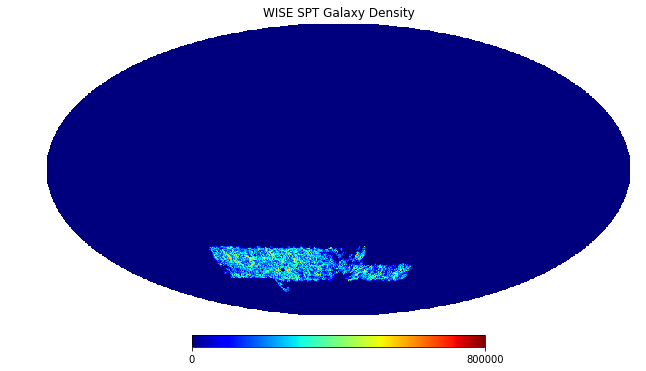

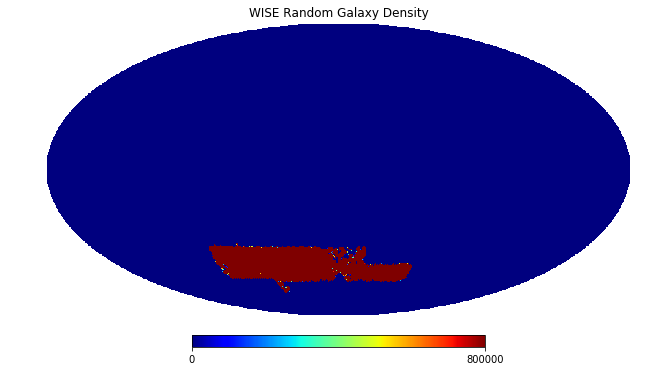

In [72]:
galmap = making_healpix_density_map(cat = wise_in_spt, nest = False, nside = 128)
hp.mollview(galmap['WEIGHT'],  nest=False, title="WISE SPT Galaxy Density", max = 8e+05)

galmap = making_healpix_density_map(cat = wise_random_in_spt, nest = False, nside = 128)
hp.mollview(galmap['WEIGHT'],  nest=False, title="WISE Random Galaxy Density", max = 8e+05)

# Adding Weight Column

In [16]:
w_sgc = cmass['WEIGHT_SYSTOT']*( cmass['WEIGHT_CP'] + cmass['WEIGHT_NOZ'] - 1. )
w_rand = np.ones(random.size)

cmass = appendColumn(cat = cmass, name='WEIGHT', value=w_sgc)
random = appendColumn(cat = random, name='WEIGHT_RAND', value=w_rand)
#appendColumn(cat = dmass, name='WEIGHT', value=dmass['CMASS_PROB']*dmass['WEIGHT_SYS'])

w_wise = np.ones(wise.size)
w_wise_rand = np.ones(wise_random_in_cmass.size)
wise = appendColumn(cat = wise, name='WEIGHT', value=w_wise)
wise_random_in_cmass = appendColumn(cat = wise_random_in_cmass, name='WEIGHT_RAND', value=w_wise_rand)

In [18]:
print 'catalog size cmass', cmass.size, random.size
print 'catalog size dmass', np.sum(dmass_spt['WEIGHT']), dmass_random.size
print 'catalog size wise(cmass)', wise.size, wise_random_in_cmass.size
print 'catalog size wise', wise_in_spt.size, wise_random_in_spt.size



 catalog size cmass 217452 10913678
catalog size dmass 114774.39081275926 20990512
catalog size wise(cmass) 202481 1626294
catalog size wise

NameError: name 'wise_in_spt' is not defined

# Cross Correlation

### Calling mocks randoms

In [25]:
cmass_mock_rand_file = np.loadtxt('/n/des/lee.5922/data/cmass_cat/qpm_mocks/mock_random_DR12_CMASS_S_50x1.rdzw')

In [27]:
random_mock = np.zeros( (cmass_mock_rand_file.shape[0],), 
    dtype = [('RA', 'float'), ('DEC', 'float'), ('Z', 'float'),('WEIGHT_FKP', 'float'), ('WEIGHT_VETO', 'int'), ('WEIGHT_RAND', 'float')])
random_mock['RA'] = cmass_mock_rand_file[:,0]
random_mock['DEC'] = cmass_mock_rand_file[:,1]
random_mock['Z'] = cmass_mock_rand_file[:,2]
random_mock['WEIGHT_FKP'] = cmass_mock_rand_file[:,3]
#random_mock['WEIGHT_VETO'] = cmass_mock_rand_file[:,4]
random_mock['WEIGHT_RAND'] = cmass_mock_rand_file[:,3]# * random_mock['WEIGHT_VETO']
#random_mock = BOSSveto(random_mock, option='SGC')

#random_mock = random_mock[(random_mock['Z'] > 0.43) & (random_mock['Z'] < 0.7)]
#cmass_mock = cmass_mock[ cmass_mock['VETO_FLAG'] == 1]
#random_mock = random_mock[ random_mock['VETO_FLAG'] == 1]

#cmass_mock_rand_file = None

In [28]:
#fitsio.write('/n/des/lee.5922/data/cmass_cat/qpm_mocks/mock_random_DR12_CMASS_N_50x1.fits', random_mock)

In [19]:
random_mock = fitsio.read('/n/des/lee.5922/data/cmass_cat/qpm_mocks/mock_random_DR12_CMASS_N_50x1.fits')
random_mock = BOSSveto(random_mock, option='SGC')
print random_mock.size

 10429802


In [34]:
#basedir =  '../data_txt/mocks_bin20/'
#os.system('mkdir '+basedir)
from systematics_module.corr import corrfunc_angular_correlation_single
from systematics_module.corr import cross_NNpairCount

basedir1 = '../data_txt/cmass/wise_sgc_ran10/'
#basedir2 = '../data_txt/cmass/corrftn_mocks_less_ran/'
os.system('mkdir '+basedir1)   
#os.system('mkdir '+basedir2)   
    
randind = np.random.choice(random_mock.size, size = random_mock.size/5)

for i in range(1, 3):
    try : 
        path = '/n/des/lee.5922/data/cmass_cat/qpm_mocks/'
        name = 'mock_galaxy_DR12_CMASS_S_QPM_{:04}.rdzw'.format(i)
        #print path+name
        
        #path = '/n/des/lee.5922/data/cmass_cat/dr12_multidark_patchy_mocks/Patchy-Mocks-DR12SGC-COMPSAM_V6C/'
        #name = 'Patchy-Mocks-DR12SGC-COMPSAM_V6C_{:04}.dat'.format(i)
        cmass_mock_file = np.loadtxt(path+name)

        #cmass_mock_file = np.loadtxt(path+'patchy_mock/Patchy-Mocks-DR12CMASS-N-V6C-Portsmouth-mass_0001.dat')
        cmass_mock = np.zeros( (cmass_mock_file.shape[0],), 
            dtype = [('RA', 'float'), ('DEC', 'float'), ('Z', 'float'),('WEIGHT_FKP', 'float'), ('WEIGHT_VETO', 'int'), ('WEIGHT', 'float')])
        cmass_mock['RA'] = cmass_mock_file[:,0]
        cmass_mock['DEC'] = cmass_mock_file[:,1]
        cmass_mock['Z'] = cmass_mock_file[:,2]
        cmass_mock['WEIGHT_FKP'] = cmass_mock_file[:,3]
        cmass_mock['WEIGHT_VETO'] = cmass_mock_file[:,4]
        #cmass_mock['VETO_FLAG'] = cmass_mock_file[:,6]
        cmass_mock['WEIGHT'] = cmass_mock_file[:,4] *cmass_mock_file[:,3]
        #cmass_mock = cmass_mock[ cmass_mock['VETO_FLAG'] == 1]
        cmass_mock = BOSSveto(cmass_mock, option='SGC')
        
        #reddening
        #cmass_mock = reddening_cat(cmass_mock, reddening_map = reddening)
        
        
        cross_NNpairCount(data1=cmass_mock, rand1=random_mock[randind], data2=wise, rand2=wise_random_in_cmass, nbins = 10, 
                          bin_slop=0.1, weight = [True, True, True, True], 
                          dir = basedir1, suffix = '_'+name)

        #angular_correlation_poisson(data = cmass_mock, rand = random_mock[randind], 
        #                            nbins=10, bin_slop=0.1, weight_data = True, weight_rand = True, 
        #                            suffix = '_'+name, dir = basedir1)
        
    except (IOError, ValueError): 
        print i, 'no files'
        pass

file save to ../data_txt/cmass/wise_sgc_ran10/npairs_cross__mock_galaxy_DR12_CMASS_S_QPM_0001.rdzw.txt
file save to ../data_txt/cmass/wise_sgc_ran10/npairs_cross__mock_galaxy_DR12_CMASS_S_QPM_0002.rdzw.txt


In [76]:
dmass_spt = None
dmass_random = None
wise = None
wise_random_in_spt = None

In [77]:
randind = np.random.choice(wise_random_in_cmass.size, size = wise_random_in_cmass.size/2 )
wise_random_in_cmass = wise_random_in_cmass[randind]

In [78]:
wise_random_in_cmass.size

745614

In [95]:
from systematics_module.corr import cross_NNpairCount
cross_NNpairCount(dmass_spt, dmass_random, twomass, twomass_random, nbins = 10, 
                  bin_slop=0.1, weight = [True, None, None, None], 
                  dir = actdir, suffix = 'twomass_x_dmass_nbins10')
    

file save to ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/npairs_cross_twomass_x_dmass_nbins10.txt


In [83]:
from systematics_module.corr import cross_NNpairCount
cross_NNpairCount(cmass, random, twomass, twomass_random_in_cmass, nbins = 10, 
                  bin_slop=0.1, weight = [True, True, True, True], 
                  dir = actdir, suffix = 'twomass_x_cmass_sgc_veto_nbins10')
    

file save to ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/npairs_cross_twomass_x_cmass_sgc_veto_nbins10.txt


In [30]:
from systematics_module.corr import cross_NNpairCount
cross_NNpairCount(cmass, random, wise, wise_random_in_cmass, nbins = 10, 
                  bin_slop=0.1, weight = [True, True, True, True], 
                  dir = actdir, suffix = 'wise_x_cmass_sgc_veto_nomoonrev_2_nbins10')
    

file save to ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/npairs_cross_wise_x_cmass_sgc_veto_nomoonrev_2_nbins10.txt


In [47]:
cross_angular_correlation(data = cmass, 
                          data2 = wise_in_cmass, 
                          rand = random, 
                          rand2= wise_random_in_cmass,
                          njack = 100, nbins=10,
                          weight = [True, True, True, True], 
                          dir = actdir,
                          suffix = '_wise_x_cmass_full_sys_cp_nz_weight_nbins10_jk100_no2')

X (1764, 2)  centers (100, 2)  tol=1e-05  maxiter=200
20 iterations  cluster sizes: [17 22 17 12  9 33 13 15  5 11 11 18 25 23 18 19 11 23 11 18  7  5 30 22
 19 13 19 13 32  8 16 12 12 12 22 27 11 21 14 11  6 21 20  9 19 16 23 20
 36 24 11 32 13 16 24 20 12 23 19 27 23 16 18 34 20 18  9 17 14 11 21 29
 16 13 11 13 12 17 16 21 22 17  8 10 32  3 18 19 21 19 21 22 19 21 32 21
 12 18 13 19]
X (778264, 2)  centers (100, 2)  tol=1e-05  maxiter=200
112 iterations  cluster sizes: [ 8938 10145  8521  8696  5558  7945  6405  5632  6168  6705  7561  5457
  9861  7760  9340  6855  6611  8231  8621  7977  6639  6878  8821 10468
  8452  8785  8011  7408  8111  6952 10344  9798  8913  4496  6052  9995
  5970  6122  8720  6961  5684  9071  8186  4270  7334  9199  9460  8906
  9122  7688  6809  8595  7791  7519  7334  9174  7306  9658  8203  6703
  8173  6401  8816  8116  8400  7552  7283  8631  8124  7617  6895  9833
  5265  7960  8022  8502  7059  7852  7785  6913  7658  9534  6914  6052
  8773  6750

In [20]:
cross_angular_correlation(data = cmass, 
                          data2 = wise_in_cmass, 
                          rand = random, 
                          rand2= wise_random_in_cmass,
                          njack = 100, nbins=10,
                          weight = [True, True, True, True], 
                          dir = actdir,
                          suffix = '_wise_x_cmass_sgc_sys_cp_nz_weight_nbins10_jk100_no2')

NameError: name 'cross_angular_correlation' is not defined

In [21]:
pcut01 = (dmass_spt['CMASS_PROB'] > 0.01 )
cross_angular_correlation(data = dmass_spt[pcut01], 
                          data2 = wise_in_spt, 
                          rand = dmass_random, 
                          rand2= wise_random_in_spt, 
                          njack = 100, nbins=10,
                          dir = actdir,
                          weight = [True, None, None, None], 
                          suffix = '_wise_x_dmass_weight_pcut01_nbins10_jk100_no2')

NameError: name 'dmass_spt' is not defined

In [51]:
cat ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/npairs_cross_wise_x_cmass_sgc_nbins10.txt

#   R_nom       meanR       meanlogR        xi        sigma_xi        DD           RR           DR           RD         npairs   
  5.2455e-02   5.4755e-02  -2.9132e+00   1.0915e-02   4.6772e-03   4.6381e+04   4.5712e+04   4.5837e+04   4.5757e+04   1.3119e+05
  8.3136e-02   8.6781e-02  -2.4527e+00   4.6734e-03   2.9606e-03   1.1528e+05   1.1409e+05   1.1434e+05   1.1449e+05   3.2628e+05
  1.3176e-01   1.3755e-01  -1.9921e+00   9.1207e-03   1.8771e-03   2.8792e+05   2.8380e+05   2.8383e+05   2.8530e+05   8.1577e+05
  2.0883e-01   2.1796e-01  -1.5318e+00   5.4130e-03   1.1917e-03   7.1516e+05   7.0418e+05   7.0509e+05   7.1044e+05   2.0301e+06
  3.3097e-01   3.4549e-01  -1.0711e+00   4.1307e-03   7.5619e-04   1.7787e+06   1.7488e+06   1.7508e+06   1.7695e+06   5.0574e+06
  5.2455e-01   5.4727e-01  -6.1117e-01   2.7462e-03   4.8087e-04   4.3966e+06   4.3247e+06   4.3253e+06   4.3840e+06   1.2505e+07
  8.3136e-01   8.6727e-01  -1.5077e-01   2.1589e-03   3.0711e-04   1.0784e+07   1.0603e+07

In [98]:
rnom, _, _, xi_test, sigma_xi_test, _,_,_,_,_ = np.genfromtxt('../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/npairs_cross_twomass_x_dmass_nbins10.txt',unpack=True)
rnom, _, _, xi_test2, sigma_xi_test2, _,_,_,_,_ = np.genfromtxt('../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/npairs_cross_wise_x_cmass_sgc_nbins10_no2.txt',unpack=True)
rnom, _, _, xi_test3, sigma_xi_test3, _,_,_,_,_ = np.genfromtxt('../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/npairs_cross_twomass_x_cmass_sgc_veto_nbins10.txt',unpack=True)



3.6310237921494775 6.756614368807273


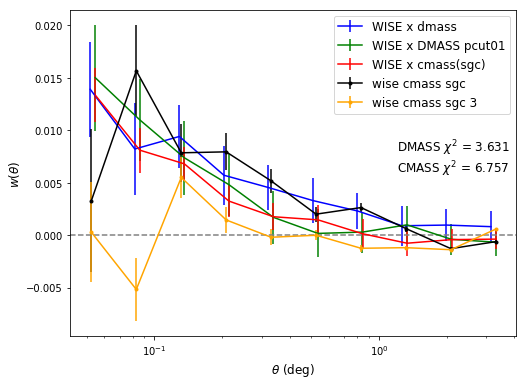

In [99]:

DAT = np.loadtxt(actdir+'acf_cross_wise_x_cmass_sgc_sys_cp_nz_weight_nbins10_jk100_no2.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt(actdir+'acf_cross_wise_x_dmass_weight_pcut01_nbins10_jk100_no2.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt(actdir+'acf_cross_wise_x_cmass_full_sys_cp_nz_weight_nbins10_jk100_no2.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_wise_x_cmass_sgc.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '-b', label='WISE x dmass')
ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '-g', label='WISE x DMASS pcut01')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '-r', label='WISE x cmass(sgc)')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='WISE x cmass(sgc)')



ax.errorbar(rnom, xi_test, yerr = sigma_xi_test, fmt = '.-k', label='wise cmass sgc ')
ax.errorbar(rnom, xi_test3, yerr = sigma_xi_test3, fmt = '.-', color = 'orange', label='wise cmass sgc 3')
#ax.errorbar(rnom, xi_test2, yerr = sigma_xi_test2, fmt = '.', color = 'orange', label='wise cmass sgc nofkp')
#chisqr = np.sum( (xi4-xi3)**2/xi_err3**2 )*1./xi3.size

chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size
print chisqr, chisqr3

ax.text(1.2, 0.008, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
ax.text(1.2, 0.006, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.set_ylim(1e-3,)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')

#fig.savefig(actdir+'/acf_wise.pdf' )

In [ ]:
#Making mask
#mind = np.arange(hp.nside2npix(512))
#reliable_hp_mask = (reddening['TEMPERATURE'] < 0.05)
#reliable_hpind = mind[reliable_hp_mask]
wise_galmap = making_healpix_density_map(cat = reliable_wise, nest = False, nside = 1024)
reliable_hpind = wise_galmap['PIXEL'][ wise_galmap['WEIGHT_RAND'] ==1 ]
boss_hpind = esutil.io.read(['/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_SGC_1024.fits', 
                             #'/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_NGC_1024.fits'
                            ],
                               combine=True)

#boss_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_NGC_1024.fits')

In [188]:
wise_random = uniform_random_on_sphere(cmass, size = cmass.size * 50 )
HPind_rand = hpRaDecToHEALPixel(wise_random['RA'], wise_random['DEC'], nside=  4096, nest= False)
reliable_rand_mask = np.in1d(HPind_rand, reliable_hpind)
reliable_wise_random =  wise_random[reliable_rand_mask]

HPind_rand512 = hpRaDecToHEALPixel(reliable_wise_random['RA'], reliable_wise_random['DEC'], nside=  128, nest= False)
reliable_rand_mask_moon_rev = np.in1d(HPind_rand512, reliable_hpind_moonrev)
reliable_wise_random =  reliable_wise_random[reliable_rand_mask_moon_rev]

In [177]:
reliable_wise['CC_FLAGS'][reliable_wise['CC_FLAGS']!='0000']

masked_array(data=['d000', '00PP', 'hh00', ..., 'd000', 'hh00', 'dd00'],
             mask=[False, False, False, ..., False, False, False],
       fill_value='N/A',
            dtype='|S4')

### Making Galaxy densty Map 

In [186]:
reliable_wise_random.size, reliable_wise.size

(16709, 2007810)

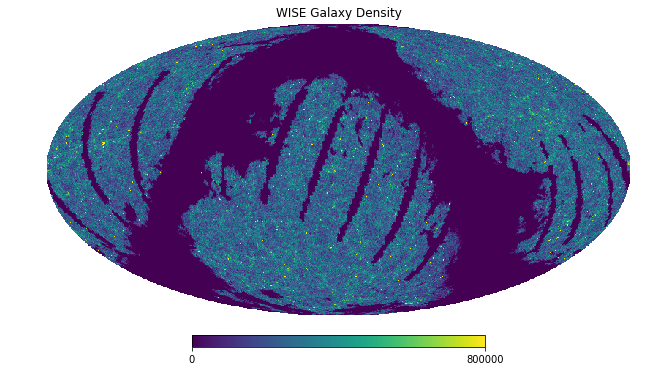

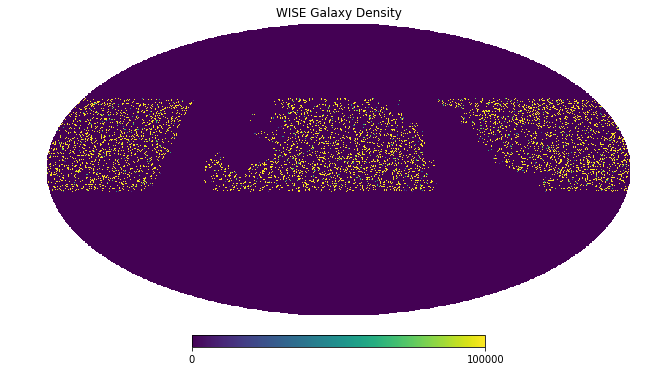

In [199]:
wise_galmap = making_healpix_density_map(cat = wise, nest = False, nside = 128)
hp.mollview(wise_galmap['WEIGHT'],  nest=False, title="WISE Galaxy Density", max = 8e+05)

wise_random_galmap = making_healpix_density_map(cat = reliable_wise_random, nest = False, nside = 128)
hp.mollview(wise_random_galmap['WEIGHT'], nest=False, title="WISE Galaxy Density", max = 1e+05)

### Cross correlation with CMASS SGC

In [160]:
#Making mask
#mind = np.arange(hp.nside2npix(512))
#reliable_hp_mask = (reddening['TEMPERATURE'] < 0.05)
#reliable_hpind = mind[reliable_hp_mask]
wise_galmap = making_healpix_density_map(cat = reliable_wise, nest = False, nside = 1024)
reliable_hpind = wise_galmap['PIXEL'][ wise_galmap['WEIGHT_RAND'] ==1 ]
boss_hpind = esutil.io.read(['/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_SGC_1024.fits', 
                             #'/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_NGC_1024.fits'
                            ],
                               combine=True)

#boss_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_NGC_1024.fits')

In [161]:
wise.size, reliable_wise.size

(3458881, 2007810)

In [151]:
#wise_random = uniform_random_on_sphere(wise, size = wise.size * 10 )
#HPind_rand = hpRaDecToHEALPixel(wise_random['RA'], wise_random['DEC'], nside=  4096, nest= False)
#reliable_rand_mask = np.in1d(HPind_rand, reliable_hpind)
#reliable_wise_random =  wise_random[reliable_rand_mask]

In [169]:
cmass_hp4096 = hpRaDecToHEALPixel(cmass['RA'], cmass['DEC'], nside=  4096, nest= False)
cmass_random_hp4096 = hpRaDecToHEALPixel(random['RA'], random['DEC'], nside=  4096, nest= False)
dmass_hp4096 = hpRaDecToHEALPixel(dmass_spt['RA'], dmass_spt['DEC'], nside=  4096, nest= False)
dmass_random_hp4096 = hpRaDecToHEALPixel(dmass_random['RA'], dmass_random['DEC'], nside=  4096, nest= False)

#twomass_hp4096 = hpRaDecToHEALPixel(reliable_twomass['RA'], reliable_twomass['DEC'], nside=  4096, nest= False)
#twomass_random_hp4096 = hpRaDecToHEALPixel(reliable_twomass_random['RA'], reliable_twomass_random['DEC'], nside=  4096, nest= False)
wise_hp1024 = hpRaDecToHEALPixel(reliable_wise['RA'], reliable_wise['DEC'], nside=  1024, nest= False)
wise_random_hp1024 = hpRaDecToHEALPixel(reliable_wise_random['RA'], reliable_wise_random['DEC'], nside=  1024, nest= False) 


In [170]:
cmass_in_wise_mask = np.in1d( cmass_hp4096, reliable_hpind )
cmass_randoms_in_wise_mask = np.in1d( cmass_random_hp4096, reliable_hpind )
dmass_in_wise_mask = np.in1d( dmass_hp4096, reliable_hpind )
dmass_radoms_in_wise_mask = np.in1d( dmass_random_hp4096, reliable_hpind )

#twomass_in_spt_mask = np.in1d( twomass_hp4096, goldmask_hpind )
#twomass_random_in_spt_mask = np.in1d( twomass_random_hp4096, goldmask_hpind )
wise_in_cmass_mask = np.in1d( wise_hp1024, boss_hpind )
wise_random_in_cmass_mask = np.in1d( wise_random_hp1024, boss_hpind )

In [171]:
cmass_in_wise = cmass[cmass_in_wise_mask]
cmass_randoms_in_wise = random[cmass_randoms_in_wise_mask]

dmass_in_wise = dmass_spt[dmass_in_wise_mask]
dmass_randoms_in_wise = dmass_random[dmass_radoms_in_wise_mask]

wise_in_spt = Cuts.keepGoodRegion(reliable_wise[reliable_wise['DEC']<-3.0])
wise_random_in_spt = Cuts.keepGoodRegion(reliable_wise_random[reliable_wise_random['DEC']<-3.0])

wise_in_cmass = reliable_wise[wise_in_cmass_mask]
wise_random_in_cmass = reliable_wise_random[wise_random_in_cmass_mask]

In [253]:
np.sum(dmass_in_wise['WEIGHT']), cmass_in_wise.size

(118260.41740635216, 229673)

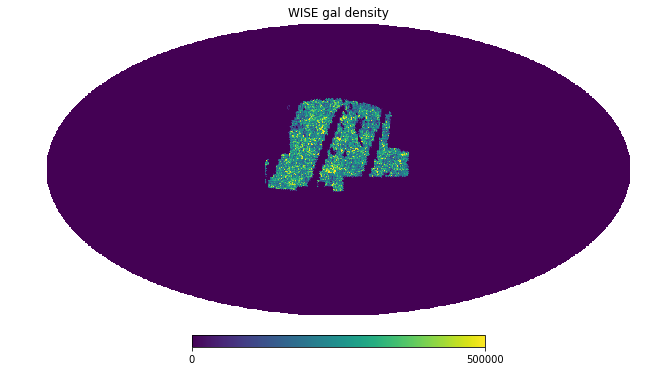

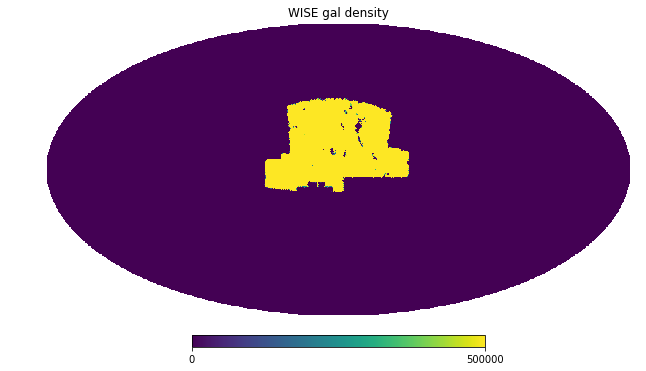

In [173]:
wise_in_cmass_galmap= making_healpix_density_map(cat = wise_in_cmass, nside = 128, nest = False)
hp.mollview(wise_in_cmass_galmap['WEIGHT'], nest=False, title="WISE gal density", max = 5e05)

wise_random_in_cmass_galmap= making_healpix_density_map(cat = wise_random_in_cmass, nside = 128, nest = False)
hp.mollview(wise_random_in_cmass_galmap['WEIGHT'], nest=False, title="WISE gal density", max = 5e05)

In [98]:
w_sgc = cmass_in_wise['WEIGHT_FKP'] * cmass_in_wise['WEIGHT_SYSTOT']*( cmass_in_wise['WEIGHT_CP'] + cmass_in_wise['WEIGHT_NOZ'] - 1. )
w_rand = cmass_randoms_in_wise['WEIGHT_FKP']
cmass_in_wise = rf.append_fields(cmass_in_wise,'WEIGHT', w_sgc, dtypes=w_sgc.dtype)
cmass_randoms_in_wise = rf.append_fields(cmass_randoms_in_wise,'WEIGHT_RAND', w_rand, dtypes=w_rand.dtype)

w_wise = np.ones(wise_in_cmass.size)
w_wise_rand = np.ones(wise_random_in_cmass.size)
wise_in_cmass = rf.append_fields(wise_in_cmass,'WEIGHT', w_wise)
wise_random_in_cmass = rf.append_fields(wise_random_in_cmass,'WEIGHT_RAND', w_wise_rand)

#w_dmass = np.ones(dmass_in_wise.size)
#w_dmass_rand = np.ones(dmass_randoms_in_wise.size)
#dmass_in_wise = rf.append_fields(dmass_in_wise,'WEIGHT', w_dmass)
#dmass_randoms_in_wise = rf.append_fields(dmass_randoms_in_wise,'WEIGHT_RAND', w_dmass_rand)

#w_dmass = np.ones(wise_in_spt.size)
#w_dmass_rand = np.ones(wise_random_in_spt.size)
#wise_in_spt = rf.append_fields(wise_in_spt,'WEIGHT', w_dmass)
#wise_random_in_spt = rf.append_fields(wise_random_in_spt,'WEIGHT_RAND', w_dmass_rand)


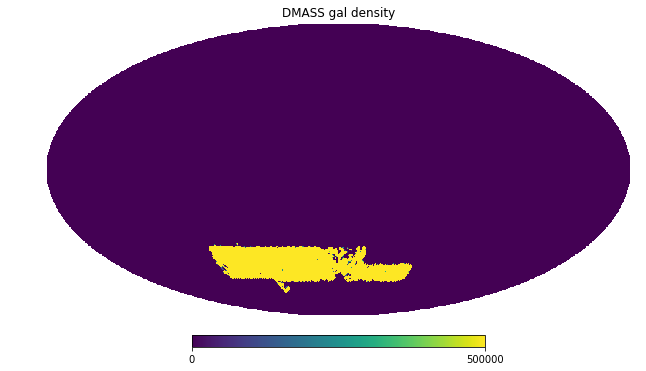

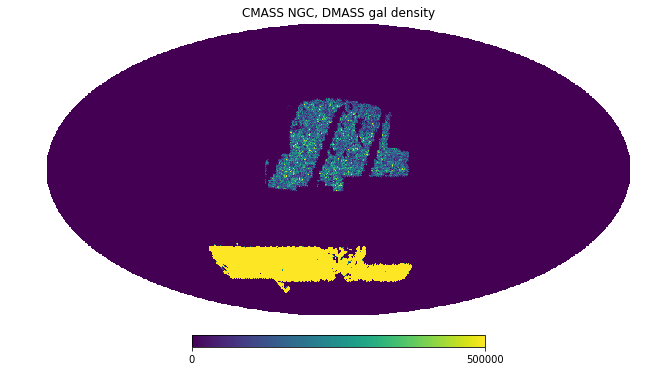

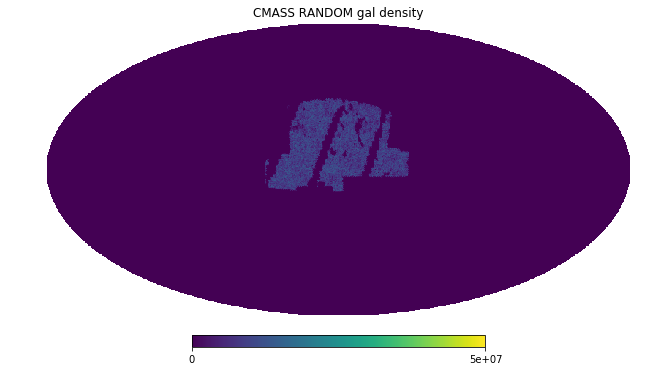

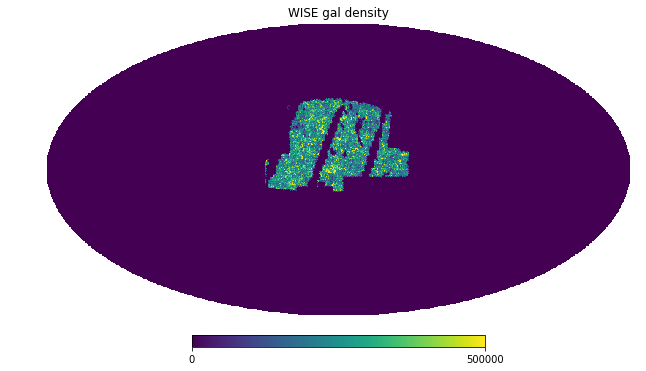

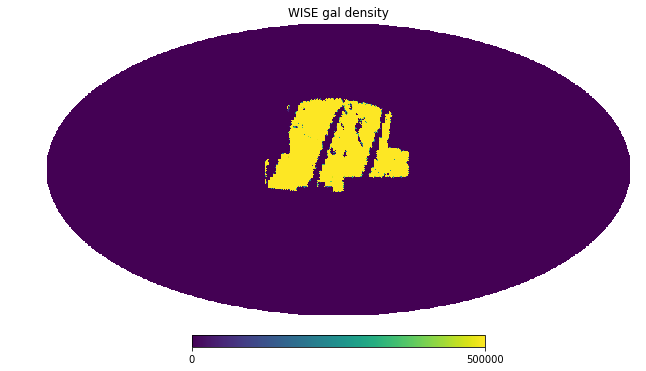

In [99]:
dmass_in_wise_galmap= making_healpix_density_map(cat = dmass_in_wise, nside = 128, nest = False)
hp.mollview(dmass_in_wise_galmap['WEIGHT'], nest=False, title="DMASS gal density", max = 5e05)

cmass_in_wise_galmap= making_healpix_density_map(cat = cmass_in_wise, nside = 128, nest = False)
hp.mollview(cmass_in_wise_galmap['WEIGHT'] + dmass_in_wise_galmap['WEIGHT'], nest=False, title="CMASS NGC, DMASS gal density", max = 5e05)

cmass_randoms_in_wise_galmap= making_healpix_density_map(cat = cmass_randoms_in_wise, nside = 128, nest = False)
hp.mollview(cmass_randoms_in_wise_galmap['WEIGHT'], nest=False, title="CMASS RANDOM gal density", max = 5e07)

wise_in_cmass_galmap= making_healpix_density_map(cat = wise_in_cmass, nside = 128, nest = False)
hp.mollview(wise_in_cmass_galmap['WEIGHT'], nest=False, title="WISE gal density", max = 5e05)

wise_random_in_cmass_galmap= making_healpix_density_map(cat = wise_random_in_cmass, nside = 128, nest = False)
hp.mollview(wise_random_in_cmass_galmap['WEIGHT'], nest=False, title="WISE gal density", max = 5e05)



In [142]:
print 'catalog size cmass', cmass_in_wise.size, cmass_randoms_in_wise.size
print 'catalog size dmass', np.sum(dmass_in_wise['WEIGHT']), dmass_randoms_in_wise.size
print 'catalog size wise', wise_in_cmass.size, wise_random_in_cmass.size
print 'catalog size wise', wise_in_spt.size, wise_random_in_spt.size


catalog size cmass 122147 6080617
catalog size dmass 76379.20251970473 13292314
catalog size wise 183984 1176714
catalog size wise 103569 670343


#### Cross Correlation Function

In [39]:
from systematics_module.corr import angular_correlation, cross_angular_correlation

In [69]:
cmass_randoms_in_wise.size, wise_random_in_cmass.size

(24877338, 4743677)

In [101]:
from systematics_module.corr import angular_correlation, cross_angular_correlation
cross_angular_correlation(data = cmass_in_wise, 
                          data2 = wise_in_cmass, 
                          rand = cmass_randoms_in_wise, 
                          rand2= wise_random_in_cmass,
                          njack = 100, nbins=10,
                          weight = [True, True, True, True], 
                          dir = actdir,
                          suffix = '_wise_x_cmass_sgc_sys_cp_nz_weight_nbins10_jk100')

X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
12 iterations  cluster sizes: [11  9  6  8 10 15 12 15 18 17 10  9  9  9  9  9  8 10 14  3 10 11  7 21
  6 15 17 14  8 16  1  1  6  9  7  5 24  2  6 16 13 11 15  1 10 15 14  7
  4 12  9 15 13 11  7 15  7 14  6  8  7  7  8  8 17 13  6  0 10 13 12 12
 14  6  8 12  9  7  9 17  9  7 10  6 10 10  6  6 13  7 13  8  7  8 12  6
 12  7 18 10]
X (122147, 2)  centers (100, 2)  tol=1e-05  maxiter=200
40 iterations  cluster sizes: [ 828 1104 1342  731  999 1228 1450 1225 1376 1455 1048 1011 1251  925
 1227 1595  447 1146 1387  793 1082 1189 1179 1597 1800 1820 1779 1656
 1601 1380 1009  842 1015  841 1322  649 1624  295 1165 1529 1682  953
 1143 1074 1727 1605 1131  946 1047 1657 1098 1486 1185 1341 1342 1015
 1286 1231  965 1250  821 1304  713 1636 1572 1485 1175   16 1214 1150
  815 1207 1714 1381 1049 1301 1251 1425 1258 1366 1325 1165 1228  571
 1087 1500 1428 1365 1679 1259 1183 1116 1249 1111 1449 1112  891  891
 2210 1369]
. . . . . . . .

In [ ]:
random_ind1 = np.random.choice(np.arange(cmass_in_wise.size), size = cmass_in_wise.size)
random_ind2 = np.random.choice(np.arange(wise_in_cmass.size), size = wise_in_cmass.size)
random_ind3 = np.random.choice(np.arange(cmass_randoms_in_wise.size), size = cmass_randoms_in_wise.size)
random_ind4 = np.random.choice(np.arange(wise_random_in_cmass.size), size = wise_random_in_cmass.size)

cross_angular_correlation(data = cmass_in_wise, 
                          data2 = wise_in_cmass, 
                          rand = cmass_randoms_in_wise, 
                          rand2= wise_random_in_cmass,
                          njack = 100, nbins=10,
                          weight = [True, True, True, True], 
                          dir = actdir,
                          suffix = '_wise_x_cmass_full_sys_cp_nz_weight_nbins10_jk100')

In [91]:
random_ind1 = np.random.choice(np.arange(dmass_in_wise.size), size = dmass_in_wise.size)
random_ind2 = np.random.choice(np.arange(wise_in_spt.size), size = wise_in_spt.size)
random_ind3 = np.random.choice(np.arange(dmass_randoms_in_wise.size), size = dmass_randoms_in_wise.size)
random_ind4 = np.random.choice(np.arange(wise_random_in_spt.size), size = wise_random_in_spt.size)


"""
cross_angular_correlation(data = dmass_in_wise[random_ind1], 
                          data2 = wise_in_spt[random_ind2], 
                          rand = dmass_randoms_in_wise[random_ind3], 
                          rand2= wise_random_in_spt[random_ind4],
                          njack = 100, nbins=10,
                          dir = actdir,
                          weight = [True, None, None, None], 
                          suffix = '_wise_x_dmass_weight_nbins10_jk100')

"""

pcut01 = (dmass_in_wise['CMASS_PROB'] > 0.01 )
cross_angular_correlation(data = dmass_in_wise[pcut01], 
                          data2 = wise_in_spt, 
                          rand = dmass_randoms_in_wise, 
                          rand2= wise_random_in_spt, 
                          njack = 100, nbins=10,
                          dir = actdir,
                          weight = [True, None, None, None], 
                          suffix = '_wise_x_dmass_weight_pcut01_nbins10_jk100')

X (1332, 2)  centers (100, 2)  tol=1e-05  maxiter=200
18 iterations  cluster sizes: [18 14 13 20 25 13 13  3 15  9 12 12 10  9 13  7 15 13  8 23 24 12  8  4
 15 15 20 16  7  6 10 24 11 19  9 19 11 23  6 15  9 18  9 12 29 11  6 15
 13 18 13 10 11 23  5 12 22 14 12 12 23 19 14 11 13 26  4 19 11 14 12 13
 11 14 18 11 16 16  6  8  7  9 14 18 14  9 20 11 21  8 14  7 20  7 11  8
  4 12  9 17]
X (443856, 2)  centers (100, 2)  tol=1e-05  maxiter=200
48 iterations  cluster sizes: [4945 4996 4989 3604 4344 4884 4790 3206 4775 4325 3506 5425 3882 3438
 4603 2893 3605 3703 3488 5044 6354 4731 3971 3192 4615 5546 5142 4770
 4527 5243 3039 5260 4558 3825 5230 4228 2970 5353 2181 4901 5358 5143
 5592 4729 5061 4039 3892 5900 4403 5509 4293 5450 3349 4764 3500 3900
 5278 5074 4568 4413 5932 4171 4859 5336 4691 4765 3049 4972 4142 5003
 4401 2355 4213 5198 6217 4129 4989 5234 4790 2746 4091 4903 3374 4510
 4648 4086 5560 5117 4334 3042 4161 4510 4850 2573 2164 4353 2416 5169
 5449 5058]
. . . . . . . .

In [263]:
random_ind = np.random.choice(np.arange(cmass_randoms_in_wise.size), size = cmass_in_wise.size*10)
angular_correlation(data = cmass_in_wise, 
                    rand = cmass_randoms_in_wise[random_ind], 
                    weight = None, suffix = '_cmass_in_wise', njack=10)

#angular_correlation(data = wise_in_cmass, 
#                    rand = wise_random_in_cmass, 
#                    weight = None, suffix = '_wise_in_cmass', njack=10)

#angular_correlation(data = dmass_in_wise, 
#                    rand = dmass_random_in_wise, 
#                    weight = None, suffix = '_dmass_in_wise', njack=10)

calculate angular correlation function
X (1102, 2)  centers (10, 2)  tol=1e-05  maxiter=200
23 iterations  cluster sizes: [107 123 104 120 108 129  96  72 103 140]
X (303702, 2)  centers (10, 2)  tol=1e-05  maxiter=200
15 iterations  cluster sizes: [31307 34354 33029 30064 24287 30365 30254 20397 31564 38081]
saving data file to :  data_txt/acf_comparison_cmass_in_wise.txt


0

In [87]:
random_ind = np.random.choice(np.arange(cmass_randoms_in_wise.size), size = cmass_in_wise.size*5)
cross_angular_correlation(data = cmass_in_wise, 
                          data2 = wise_in_cmass, 
                          rand = cmass_randoms_in_wise[random_ind], 
                          rand2= wise_random_in_cmass, njack = 10,  
                          weight = [None, None, None, None], suffix = '_wise_x_cmass_sgc_no4')


cross_angular_correlation(data = dmass_in_wise, 
                          data2 = wise_in_spt, 
                          rand = dmass_randoms_in_wise, 
                          rand2= wise_random_in_spt, njack = 10,  
                          weight = [True, True, True, True], suffix = '_wise_x_dmass_no3')

X (698, 2)  centers (10, 2)  tol=1e-05  maxiter=200
11 iterations  cluster sizes: [ 78  87  68  66  78 101  67  61  54  38]
X (122147, 2)  centers (10, 2)  tol=1e-05  maxiter=200
19 iterations  cluster sizes: [14629 15199 13126 10299 11860 15360 11452 11070 10359  8793]
saving data file to :  data_txt/acf_cross_wise_x_cmass_sgc_no4.txt
X (529, 2)  centers (10, 2)  tol=1e-05  maxiter=200
21 iterations  cluster sizes: [70 42 43 45 58 75 49 44 45 58]
X (70039, 2)  centers (10, 2)  tol=1e-05  maxiter=200
17 iterations  cluster sizes: [7773 7962 7359 5763 6937 8907 6475 6630 6377 5856]
saving data file to :  data_txt/acf_cross_wise_x_dmass_no3.txt


In [76]:
m1, m2 = np.mgrid[0:20, 0:20]
m1.shape

(20, 20)

0.39915074364242653 0.2788734979408531


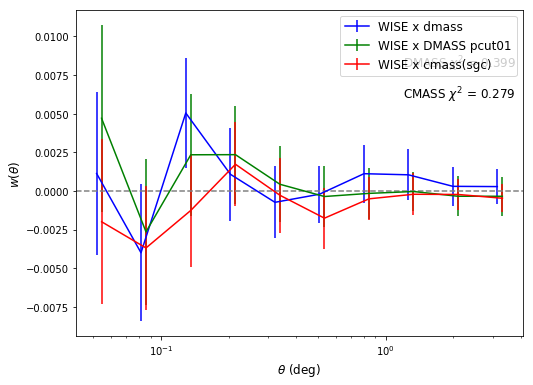

In [103]:
DAT = np.loadtxt(actdir+'acf_cross_wise_x_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt(actdir+'acf_cross_wise_x_dmass_weight_pcut01_nbins10_jk100.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt(actdir+'acf_cross_wise_x_cmass_full_sys_cp_nz_weight_nbins10_jk100.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_wise_x_cmass_sgc.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '-b', label='WISE x dmass')
ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '-g', label='WISE x DMASS pcut01')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '-r', label='WISE x cmass(sgc)')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='WISE x cmass(sgc)')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
#chisqr = np.sum( (xi4-xi3)**2/xi_err3**2 )*1./xi3.size

chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size
print chisqr, chisqr3

ax.text(1.2, 0.008, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
ax.text(1.2, 0.006, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.set_ylim(1e-3,)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')

#fig.savefig(actdir+'/acf_wise.pdf' )

0.6918689924011874 1.030205009992224


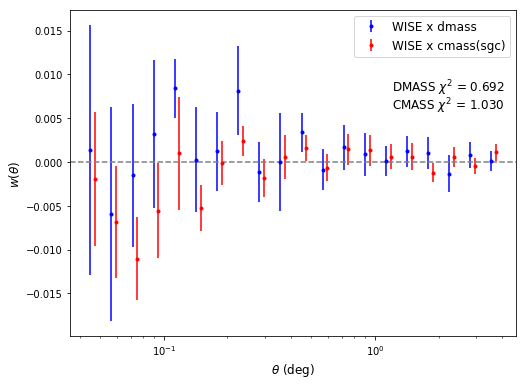

In [105]:
DAT = np.loadtxt('../data_txt/acf_cross_wise_x_dmass_no3.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('../data_txt/acf_cross_wise_x_cmass_sgc_no4.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_wise_x_cmass_sgc.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '.b', label='WISE x dmass')
#ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='cmass auto')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '.r', label='WISE x cmass(sgc)')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='WISE x cmass(sgc)')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
#chisqr = np.sum( (xi4-xi3)**2/xi_err3**2 )*1./xi3.size

chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size
print chisqr, chisqr3

ax.text(1.2, 0.008, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
ax.text(1.2, 0.006, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.set_ylim(1e-3,)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')